In [1]:
import numpy as np
import mne
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

file_path = "/Users/kuba/Downloads/s279157.mff"

try:
    # Attempt to load the .mff file
    raw = mne.io.read_raw_egi(file_path, preload=True)
    print("File loaded successfully!")
except FileNotFoundError:
    print(f"File not found: {file_path}")

Reading EGI MFF Header from /Users/kuba/Downloads/s279157.mff...
    Reading events ...
    Assembling measurement info ...
    Excluding events {} ...
Reading 0 ... 315351  =      0.000 ...  1261.404 secs...
File loaded successfully!


In [2]:
raw

<RawMff | signal1.bin, 258 x 315352 (1261.4 s), ~621.0 MiB, data loaded>

In [3]:
mne.events_from_annotations(raw)

Used Annotations descriptions: [np.str_('stan')]


(array([[  8371,      0,      1],
        [ 11135,      0,      1],
        [ 14179,      0,      1],
        [ 44712,      0,      1],
        [ 47527,      0,      1],
        [ 74312,      0,      1],
        [ 77266,      0,      1],
        [224051,      0,      1],
        [227230,      0,      1],
        [297006,      0,      1],
        [300306,      0,      1],
        [315322,      0,      1]]),
 {np.str_('stan'): 1})

start: 33.484, end: 38.4
Using matplotlib as 2D backend.


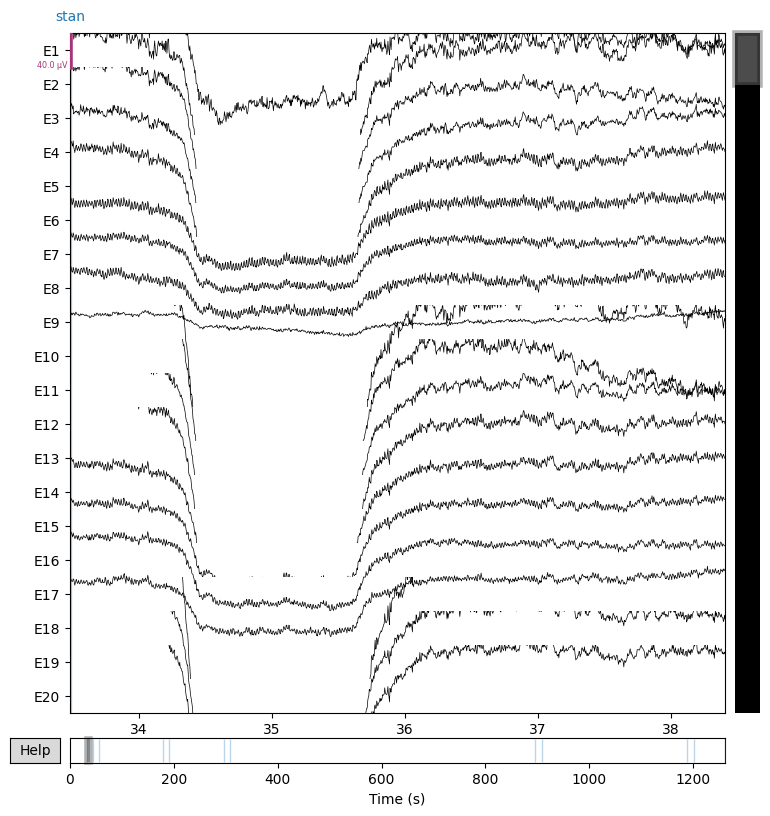

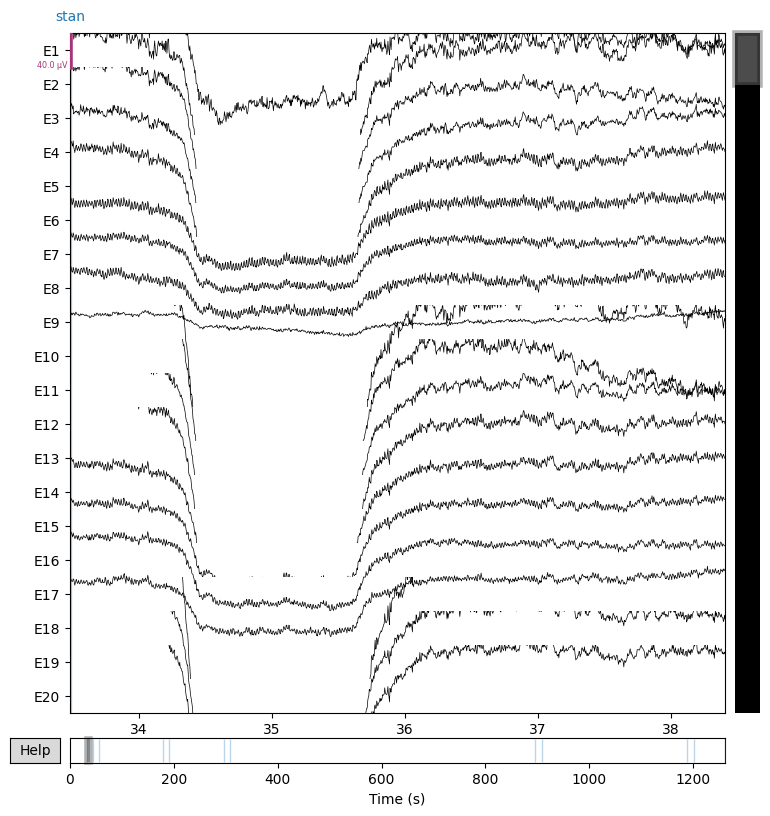

In [4]:
start_time = 8371 / raw.info['sfreq']
end_time = 9600 / raw.info['sfreq']    
print(f"start: {start_time}, end: {end_time}")
raw.plot(start=start_time, duration=(end_time - start_time))

In [5]:
raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=90.)

tstep = 2.0
events_clean = mne.make_fixed_length_events(raw_filtered, duration=tstep)
epochs_clean = mne.Epochs(raw_filtered, events_clean,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

events_raw= mne.make_fixed_length_events(raw.copy(), duration=tstep)
epochs_raw = mne.Epochs(raw.copy(), events_raw,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.9s


Not setting metadata
630 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 630 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
630 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 630 events and 501 original time points ...
0 bad epochs dropped


In [6]:
events_clean.shape
epochs_clean.get_data().shape

(630, 258, 501)

In [7]:
epochs_clean.get_data()[:,0,:].shape

(630, 501)

In [8]:
epochs_clean.get_data().shape[0]

630

In [9]:
# raw_alpha.plot(duration=40, n_channels=1)
# filtered_alpha.plot(duration=40, n_channels=1)

In [13]:
# Dane treningowe
split_idx = int(0.8 * epochs_clean.get_data().shape[0])

r_raw = np.array(epochs_raw.get_data())[:split_idx, 0,]   # (batches, samples)
f_raw = np.array(epochs_clean.get_data())[:split_idx, 0,]

scaler_r = StandardScaler()
scaler_f = StandardScaler()

r = scaler_r.fit_transform(r_raw.reshape(-1, 1)).reshape(r_raw.shape)
f = scaler_f.fit_transform(f_raw.reshape(-1, 1)).reshape(f_raw.shape)

test_raw = np.array(epochs_raw.get_data())[split_idx:, 0,]
fTest_raw = np.array(epochs_clean.get_data())[split_idx:, 0,]

test = scaler_r.transform(test_raw.reshape(-1, 1)).reshape(test_raw.shape)
fTest = scaler_f.transform(fTest_raw.reshape(-1, 1)).reshape(fTest_raw.shape)

print(f"shape raw {r.shape}, shape filtered {f.shape}, shape rawTest {test.shape}, shape filteredTest {fTest.shape}")

shape raw (504, 501), shape filtered (504, 501), shape rawTest (126, 501), shape filteredTest (126, 501)


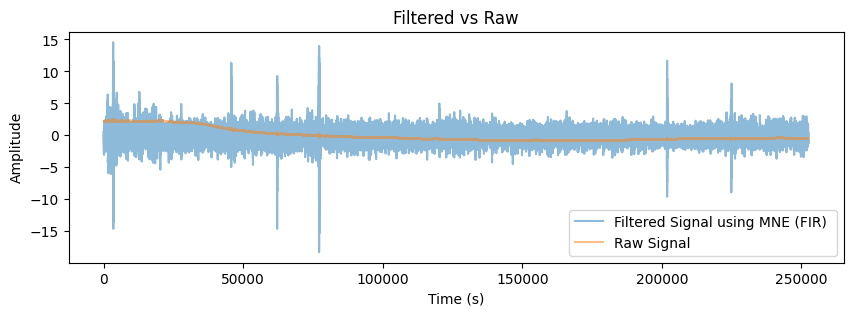

In [14]:
plt.figure(figsize=(10, 3))
plt.plot(f.flatten(), label="Filtered Signal using MNE (FIR) ", alpha=0.5)
plt.plot(r.flatten(), label="Raw Signal", alpha=0.5)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Filtered vs Raw")
plt.show()

In [15]:
np.mean(f.flatten())

np.float64(1.850195833579927e-17)

In [ ]:
device = torch.device("mps")
#format is (batch_size, channels, length)
x_train = torch.tensor(r, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(fTest, dtype=torch.float32).unsqueeze(1)

x_train = x_train.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
X_test = X_test.to(device)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
print(f"xtrain: {x_train.shape},  ytrain: {y_train.shape} xtrain: {X_test.shape},  ytrain: {y_test.shape}")

xtrain: torch.Size([504, 1, 501]),  ytrain: torch.Size([504, 1, 501]) xtrain: torch.Size([126, 1, 501]),  ytrain: torch.Size([126, 1, 501])
Liczba batchy w train_loader: 16


In [18]:
# Liczba batchy
print(f"Liczba batchy w train_loader: {len(train_loader)}")

# Rozmiar danych w każdym batchu
for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}: x -> {batch_x.shape}, y -> {batch_y.shape}")
    break  # Wyświetl tylko pierwszy batch

Liczba batchy w train_loader: 16
Batch 1: x -> torch.Size([32, 1, 501]), y -> torch.Size([32, 1, 501])


In [20]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]
        #obcina zeby bylo causal z przodu

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding) 
        self.tanh = nn.Tanh()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding) 
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.tanh, self.dropout1,
                                 self.conv2, self.chomp2, self.tanh, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        #jeseli takie same in out to git jak nie to konwuluje zeby ze stride 1 zeby bylo wielkosci outputu
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size, dropout):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

tcn_model = TemporalConvNet(num_inputs=1, num_channels=[32, 64, 128, 128, 64, 32, 1], kernel_size=5, dropout=0.0).to(device)
criterion = nn.MSELoss() # czy lepiej SmoothL1Loss
optimizer = optim.Adam(tcn_model.parameters(), lr=0.001)

/Users/kuba/University/Licenjat/venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [16]:
print((y_train - x_train).abs().mean())

tensor(1.0671, device='mps:0')


In [17]:
tcn_model.train()

epochs = 4000
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = tcn_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 100 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f"{epoch} loss: {avg_loss}")

0 loss: 0.9972828067839146
100 loss: 0.46762917935848236
200 loss: 0.41924949549138546
300 loss: 0.3953877277672291
400 loss: 0.4065050408244133
500 loss: 0.4030705075711012
600 loss: 0.36254558339715004
700 loss: 0.32918938249349594
800 loss: 0.30555039644241333
900 loss: 0.2966774981468916
1000 loss: 0.284140951000154
1100 loss: 0.2629096722230315
1200 loss: 0.25892296247184277
1300 loss: 0.2606790969148278
1400 loss: 0.2516560796648264
1500 loss: 0.20784065872430801
1600 loss: 0.20693290140479803
1700 loss: 0.19825159944593906
1800 loss: 0.18227038905024529
1900 loss: 0.16523778531700373
2000 loss: 0.1796689061447978
2100 loss: 0.1615467336960137
2200 loss: 0.16904556471854448
2300 loss: 0.14212462585419416
2400 loss: 0.139096490573138
2500 loss: 0.12681250972673297
2600 loss: 0.12061937665566802
2700 loss: 0.12584268068894744
2800 loss: 0.10024523828178644
2900 loss: 0.08725606882944703
3000 loss: 0.09128607669845223
3100 loss: 0.11736603500321507
3200 loss: 0.080213095061481
3300 

In [ ]:
torch.save(tcn_model.state_dict(), "tcn_model.pth")

In [7]:
total_params = sum(p.numel() for p in tcn_model.parameters() if p.requires_grad)
print(f"parametrow: {total_params}")
tcn_model.train()

parametrow: 422346


TemporalConvNet(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(4,))
      (chomp1): Chomp1d()
      (tanh): Tanh()
      (dropout1): Dropout(p=0.0, inplace=False)
      (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(4,))
      (chomp2): Chomp1d()
      (dropout2): Dropout(p=0.0, inplace=False)
      (net): Sequential(
        (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(4,))
        (1): Chomp1d()
        (2): Tanh()
        (3): Dropout(p=0.0, inplace=False)
        (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(4,))
        (5): Chomp1d()
        (6): Tanh()
        (7): Dropout(p=0.0, inplace=False)
      )
      (downsample): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
    )
    (1): TemporalBlock(
      (conv1): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(2,))
      (chomp1): Chomp1d()
      (tanh): Tanh()
      (dropout1): Dropout(p=0.0, i

In [22]:
print(X_test.flatten()[:20])

tensor([-0.4559, -0.4618, -0.4559, -0.4626, -0.4613, -0.4662, -0.4701, -0.4762,
        -0.4755, -0.4806, -0.4820, -0.4798, -0.4799, -0.4843, -0.4814, -0.4815,
        -0.4861, -0.4830, -0.4773, -0.4802], device='mps:0')


In [21]:
tcn_model.load_state_dict(torch.load("tcn_model.pth"))

<All keys matched successfully>

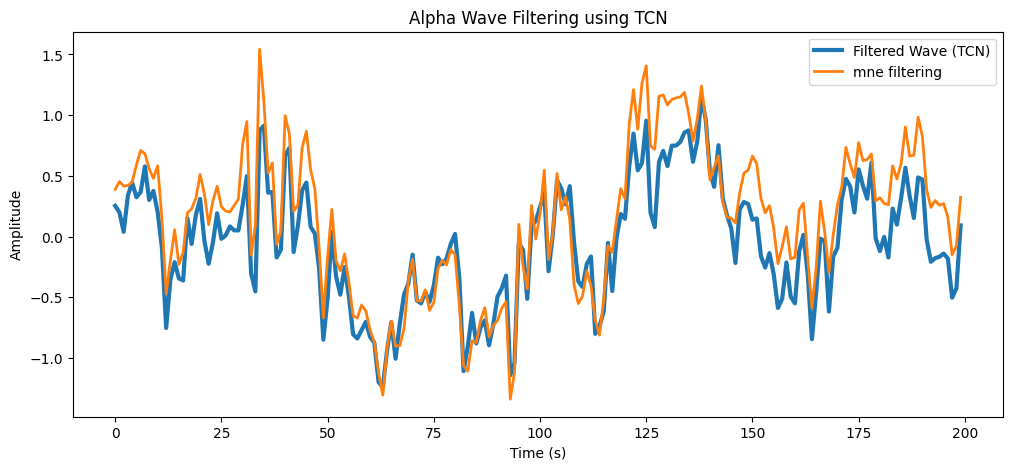

In [29]:
tcn_model.eval()

with torch.no_grad():
    y_pred = tcn_model(X_test)

y_pred = y_pred.squeeze(1).cpu().flatten() 
y_test = y_test.cpu().flatten()

plt.figure(figsize=(12, 5))

plt.plot(y_pred[800:1000], label="Filtered Wave (TCN)", linewidth=3)

plt.plot(y_test[800:1000], label="mne filtering", linewidth=2)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Alpha Wave Filtering using TCN")
plt.show()

In [ ]:
from sklearn.metrics import r2_score

# Oblicz R² 
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")
# przez artefakty taka niedokladna chyba

R² Score: 0.5015285624854795


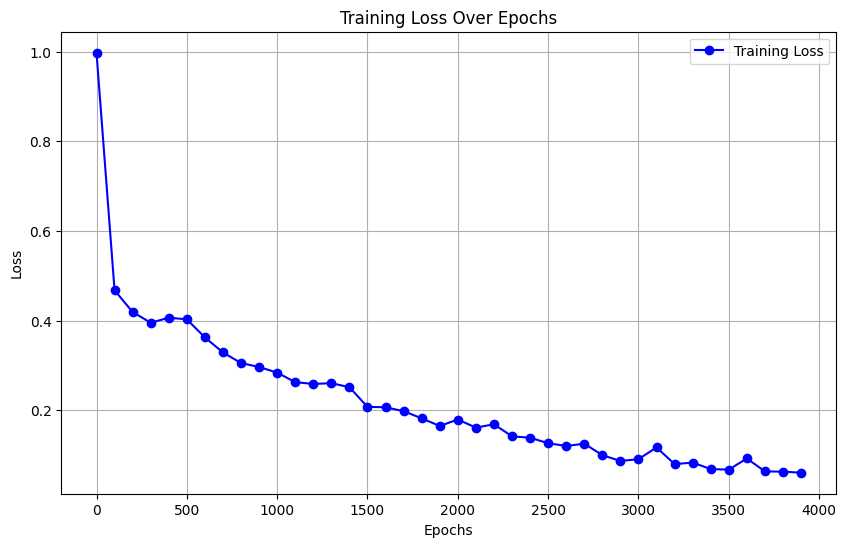

In [30]:
import matplotlib.pyplot as plt

# Training loss data
epochs = list(range(0, 4000, 100))  # Epochs at intervals of 100
loss_values = [
    0.9972828067839146, 0.46762917935848236, 0.41924949549138546, 0.3953877277672291,
    0.4065050408244133, 0.4030705075711012, 0.36254558339715004, 0.32918938249349594,
    0.30555039644241333, 0.2966774981468916, 0.284140951000154, 0.2629096722230315,
    0.25892296247184277, 0.2606790969148278, 0.2516560796648264, 0.20784065872430801,
    0.20693290140479803, 0.19825159944593906, 0.18227038905024529, 0.16523778531700373,
    0.1796689061447978, 0.1615467336960137, 0.16904556471854448, 0.14212462585419416,
    0.139096490573138, 0.12681250972673297, 0.12061937665566802, 0.12584268068894744,
    0.10024523828178644, 0.08725606882944703, 0.09128607669845223, 0.11736603500321507,
    0.080213095061481, 0.0836692713201046, 0.06916348822414875, 0.06798804923892021,
    0.09278315026313066, 0.06394385523162782, 0.06344907032325864, 0.061048992443829775
]

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()